# Classification /extraction 
--- 

we should consider only some properties derivated  from items but in this case we can build a vocabulary of property initially for two categories **Culture Representative** and **Culture Agnostic**. 


### How should we chose properties from item of Culture Agnostic and Culture Representative? 
### Training  Phase:

--- 

### Step 1: Building 1 vocabulary of properties associated to Culture Representative and Culture Agnostic 
In this phase, for every sample $ item_{i} $ associated to, we put all its properties  into a set  $S_{P} $
### Step 2: Embedded vectors of properties for every item 
In this case we associate a binary vector for every $item_{i} $ where for every possible property we associate 1 if it has that property $P_k$ otherwise 0.
### Step 3: Compute the centroids for every category C.A C.R, C.E.X
Now, after the preprocessed data we compute the centroid (like mean over every property $P_k$ on all samples) $C_{CA} $ and $C_{CR} $.
### Step 4: We compute the euclidean distance among properties and centroids
for every sample we compute distance among each property and centroids, so we will interpret strong relationship of some  properties wrt culture concepts while for concept more neutrals
### Step 5: Corresponding the similarity to every property with some methods wrt centroids
Every property, will have a weight computed following the importance of distance wrt centroids $C_{C.A} $ and  $ C_{C.R}$ : 
#### Case 1: Kernel Funtion (Kernel Density Estimation)
we will use kernel to give a more flexible weight : $ w_{gauss}(item_{i})=\exp{(-\frac{d_{C}(item_{i})}{2*\sigma^2})} $ .
We can compute **$\sigma$** like a constant such that influences the area of neighbours entities: 
we can compute it as: $\sigma=\frac{1}{\sqrt{2}*mean \space of \space distance}$, can be optimized empirically 
**The Gaussian kernel has the advantage of providing a gradual decrease in weight rather than a linear or inversely proportional decrease, allowing us to assign greater weight to nearby entities without excluding those that are further away.** .
We normalize all weights wrt the sum following weights wrt centroids

### Test Phase:

### Step 1: Compute distance among every element wrt to the both centroids
we compute per every $item_i$  and every feature of kind: $P_{123},P_{2345} $ ecc... the euclidean distance
### Step 2: Compute similarity for every test sample(with kernel approach) for both centroids
this pass helps us to understand in which direction a sample should go to the centroids for both centroids 
### Step 3: Given averaged sum of the importance of feature of samples 
in this step we compute, Culture and Agnostic_score= $ \sum_{fi=1}^{N_feat} item_{fi}* importance \space of  \space features $  the secnond term is measured in previous case
### Step 4 : Then, to emphasize the influence of entities closer to the centroids, we multiply the weighted score by the similarity.
So, ultimately, we multiply the weighted score by similarity to get a total score that is more sensitive to the entity's proximity to the centroids. This helps make a more accurate prediction based on how much the entity resembles the cultural or agnostic centers.

total_culture_score=$ Culture \space and  \space Agnostic_score * similarity \space of \space distance \space of \space test_sample $ repeated for every class score
total_agnostic_score = ... 
### Step 5: Classification based on best result
if total_culture_score > total agnostic_score  -> **Culture Representative**









# Step 0: Building a Vocabulary with all properties of training items

In [2]:
from datasets import load_dataset
import pandas as pd
import torch as t 
import numpy as np
import matplotlib.pyplot as plt
from wikidata.client import Client
from itertools import islice
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import euclidean
import urllib.error
import json
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

In [3]:
ds=load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_set=train_data=pd.DataFrame(ds["train"])
test_set=train_data=pd.DataFrame(ds["validation"])
list_category=set(list(train_set.category))
print(list_category)
list_subcategory=set(list(train_set.subcategory))
X_train=train_set.values
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(X_train) # stamp all dataset
#print(X_train.shape) 
validation_set=pd.DataFrame(ds["validation"])
X_valid=validation_set.values
print(X_valid)

{'transportation', 'media', 'performing arts', 'politics', 'literature', 'gestures and habits', 'philosophy and religion', 'sports', 'fashion', 'geography', 'history', 'films', 'biology', 'food', 'comics and anime', 'visual arts', 'books', 'music', 'architecture'}
[['http://www.wikidata.org/entity/Q32786' '916' '2012 film by M. Mohanan'
  ... 'films' 'film' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q371' '!!!'
  'American dance-punk band from California' ... 'music' 'musical group'
  'cultural representative']
 ['http://www.wikidata.org/entity/Q3729947' '¡Soborno!'
  'Mort & Phil comic' ... 'comics and anime' 'comics'
  'cultural representative']
 ...
 ['http://www.wikidata.org/entity/Q10779' 'Zwenkau'
  'city in the district of Leipzig, in the Free State of Saxony, Germany'
  ... 'geography' 'city' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q245296' 'zydeco'
  'music genre evolved in southwest Louisiana which blends blues, rhythm and blues, and music indigen

In [7]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]
#print(X_train.shape[0])
def extract_sample_from_cat(X,cat):
    l=list()
    for elem in X:
        if elem[4]==cat:
            l.append(elem[0])
    return np.array(l)
client = Client()

In [ ]:


vocabulary=list()
def build_vocabulary(cat):
    vocabulary_subset=list()
    list_sample_cat=extract_sample_from_cat(X_train,cat)
    number_list_sample_cat=len(list_sample_cat)
    #print("sample category: "+cat)
    #print(len(list_sample_cat))
    set_properties=list()
    #set_properties=np.array(set_properties)
    for url in list_sample_cat:
        entity_train=extract_entity_id(url)
        #-----Check on entity train
        if not entity_train or not entity_train.startswith("Q"): #verify if entity_id starts with Q
            continue
        try:
            item = client.get(entity_train, load=True)
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            continue
        #------
        claim_item_i=item.data.get("claims",{})
       # print(claim_item_i)
        #print(len(claim_item_i))
        set_property_item=set()
        for prop_id,values in islice(claim_item_i.items(),len(claim_item_i)):
            #prop_entity = client.get(prop_id, load=True)
            #label = prop_entity.label
            #print(f"{prop_id} = {label} ({len(values)} statement{'s' if len(values) != 1 else ''})")
            set_property_item.add(str(prop_id))
        set_properties.append(set_property_item)

    print("Category:"+cat+" collected")
    counter=Counter()
    for s in set_properties:
        for prop in s:
            counter[prop]+=1
    frequency_prop=counter
    #frequency_prop=count_frequency_prop_id(set_properties)
    sorted_prop=frequency_prop.most_common()
   # print(sorted_prop)
    #threshold=int(len(sorted_prop)*0.6)
    # ERROR
    #------
    th=0
    if(number_list_sample_cat>=429):
        th=0.35
    elif number_list_sample_cat>=300:
        th=0.4
    elif number_list_sample_cat>=150:
        th=0.45
    #th=dynamic_threshold(number_list_sample_cat)
    for prop_i,count in sorted_prop:
        support_categories=count/number_list_sample_cat
        if support_categories>=th: #min support 
            vocabulary_subset.append(prop_i)
        #if len(vocabulary_subset)>=6: #the first top k
            #break
    #print("Updated Vocabulary",vocabulary_subset) 
    #-----       
    return vocabulary_subset
        #set_property_item.clear()
    #print("intersection of sample belongs"+cat,set.intersection(*set_properties))

        #label = prop_entity.labels
        #print(claim_item_i)


Category:books collected
Category:transportation collected
Category:gestures and habits collected
Category:performing arts collected
Category:food collected
Category:biology collected
Category:history collected
Category:architecture collected
Category:philosophy and religion collected
Category:sports collected
Category:media collected
Category:music collected
Category:comics and anime collected
Category:films collected
Category:fashion collected
Category:visual arts collected
Category:politics collected
Category:literature collected
Category:geography collected
Updated Vocabulary: for categories ['P106', 'P569', 'P227', 'P6366', 'P646', 'P373', 'P18', 'P495', 'P641', 'P279', 'P19', 'P244', 'P1566', 'P159', 'P214', 'P31', 'P27', 'P571', 'P345', 'P17', 'P625', 'P21', 'P131', 'P910', 'P8189', 'P856']


### Execute for category

In [ ]:
with  ThreadPoolExecutor(max_workers=10) as executor:
    results=list(executor.map(build_vocabulary,list_category))

for vocab in results:
    vocabulary.extend(vocab)
vocabulary=list(set(vocabulary))
print("Updated Vocabulary: for categories",vocabulary)
with open("vocabulary_category.json", "w") as f:
    json.dump(vocabulary, f)
#Updated Vocabulary: for categories ['P495', 'P279', 'P345', 'P910', 'P17', 'P571', 'P373', 'P18', 'P625', 'P856', 'P244', 'P646', 'P31', 'P131', 'P641']

### Execute for subcategory

In [ ]:
with  ThreadPoolExecutor(max_workers=10) as executor:
    results=list(executor.map(build_vocabulary,list_subcategory))

for vocab in results:
    vocabulary.extend(vocab)
vocabulary=list(set(vocabulary))
print("Updated Vocabulary: for categories",vocabulary)
#Updated Vocabulary: for categories ['P495', 'P279', 'P345', 'P910', 'P17', 'P571', 'P373', 'P18', 'P625', 'P856', 'P244', 'P646', 'P31', 'P131', 'P641']

6251
P646: 315
P18: 261
P279: 251
P31: 229
P373: 219
P495: 184
P5456: 134
P527: 129
P3417: 54
P1889: 51
P361: 51
P186: 49
P571: 48
P17: 48
P227: 47
P2581: 44
P8814: 44
P244: 43
P8431: 43
P106: 43
P1705: 42
P21: 42
P2012: 38
P569: 38
P735: 37
P910: 36
P27: 35
P1417: 34
P19: 34
P856: 32
P1343: 31
P214: 31
P8189: 30
P1412: 30
P2671: 29
P734: 29
P8408: 28
P176: 27
P10832: 27
P443: 26
P213: 25
P12086: 23
P8313: 23
P2347: 21
P1821: 21
P691: 21
P4342: 21
P268: 20
P345: 20
P1559: 20
P11293: 19
P3827: 19
P13049: 18
P12596: 17
P6366: 17
P1245: 17
P12385: 17
P12800: 17
P1296: 17
P166: 17
P1617: 16
P138: 16
P9769: 16
P508: 15
P4839: 15
P5008: 15
P6262: 15
P570: 15
P349: 14
P10283: 14
P2163: 14
P3368: 14
P269: 14
P2002: 13
P11137: 13
P2079: 13
P20: 13
P366: 12
P4985: 12
P2892: 11
P950: 11
P486: 11
P672: 11
P8687: 11
P6104: 11
P3259: 11
P11408: 11
P1006: 11
P3553: 10
P2013: 10
P935: 10
P2341: 10
P937: 10
P6640: 10
P7902: 10
P7033: 9
P5930: 9
P276: 9
P2572: 9
P12098: 9
P460: 9
P1014: 9
P1051: 8
P5019

# Step 1: Embedding con vettori binari 1/0 

In [10]:
 

from scipy.spatial.distance import euclidean
from sklearn.feature_selection import mutual_info_classif

def weight_property(X,Y):
    mi_result=mutual_info_classif(X, Y,discrete_features=True)
    print(f"MI result {mi_result}")
    weighted_mi_result=mi_result/np.sum(mi_result)
    print(f"MI result{weighted_mi_result}")
    return weighted_mi_result

def weight_distance_estimation(X1,X2,weights):
   
    dist=np.sqrt(np.sum((X1 - X2)**2))
    weights=1/(dist+1e-5)
    return weights
def extract_dictionary_property(X):
    d=dict()
    for i in range(0,X.shape[0]):
        item=client.get(extract_entity_id(X[i,0]),load=True)
        claim_item_i=item.data.get("claims",{})
        set_p=set()
        for prop_id,__ in islice(claim_item_i.items(),len(claim_item_i)):
            set_p.add(str(prop_id))
        d[i]=set_p
        print(f"sample {i} processed")
    return d
# too slow :( try parallelization
#----------
def embedding_sample(X,vocabulary):
    X_train_emb=np.zeros((X.shape[0],len(vocabulary)),dtype=np.int32)
   # X_train_emb=np.zeros(shape=(X.shape[0],len(vocabulary)))
    #print(f"Processing {X.shape[0]} sample")
    def process_sample(j):
        ent=extract_entity_id(X[j,0])
        if not ent or not ent.startswith("Q"): #verify if entity_id starts with Q
            return j,None
        try:
            item= client.get(ent, load=True)
            #print(f"item raccolte sample {j}")
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            return j,None
        item_j = client.get(ent, load=True)
        claim_item_i=item.data.get("claims",{})
        #print("processed:",claim_item_i)
        set_p=set()
        for prop_id,__ in islice(claim_item_i.items(),len(claim_item_i)):
            set_p.add(str(prop_id))
        sample=np.zeros(len(vocabulary),dtype=np.int32)
        for v in range(0,len(vocabulary)):
            if vocabulary[v] in set_p:
                sample[v]=1
        print(f"embedded sample {j,sample}")
        return j,sample
        #np.arange(X_train_emb=X[j,6]
        #print(f"Update X_train_emb {j}: {X_train_emb[j]}")
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(process_sample, range(X.shape[0]))
    for i,sample_embedded in results:
        if sample_embedded is not None:
            X_train_emb[i]=sample_embedded
    return X_train_emb

In [5]:
# insert of binary vectors
#------------
#X_embed_train=embedding_sample(X_train,vocabulary)
with open("vocabulary_category.json","r",encoding="utf-8") as f:
    vocabulary_j=json.load(f)
print(vocabulary_j)
#set_properties_train_sample=extract_dictionary_property(X_train)
print("Embedding culture representative samples")
culture_representative_train=embedding_sample(X_train[X_train[:,6]=='cultural representative'],vocabulary_j)
print("--Embedding culture agnostic sample")
culture_agnostic_train=embedding_sample(X_train[X_train[:,6]=='cultural agnostic'],vocabulary_j)
print("--Embedding Culture exclusive sample")
culture_exclusive_train=embedding_sample(X_train[X_train[:,6]=='cultural exclusive'],vocabulary_j)

print(f"culture_agnostic_train: {culture_agnostic_train}")
print(f"cutlure agnostic shape {culture_agnostic_train.shape}")

print(f"culture_representative_train {culture_representative_train}")
print(f"culture_representative_train shape {culture_representative_train.shape}")

print(f"culture_exlusive_train {culture_exclusive_train}")
print(f"culture_exlusive_train shape {culture_exclusive_train.shape}")

np.savez("train_sample_embeddings.npz",representative=culture_representative_train,agnostic=culture_agnostic_train,exclusive=culture_exclusive_train)


['P106', 'P569', 'P227', 'P6366', 'P646', 'P373', 'P18', 'P495', 'P641', 'P279', 'P19', 'P244', 'P1566', 'P159', 'P214', 'P31', 'P27', 'P571', 'P345', 'P17', 'P625', 'P21', 'P131', 'P910', 'P8189', 'P856']
Embedding culture representative samples
embedded sample (9, array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1], dtype=int32))
embedded sample (7, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1], dtype=int32))
embedded sample (4, array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0], dtype=int32))
embedded sample (5, array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1], dtype

In [5]:
def numerical_label(Y):
    Y_index=np.zeros(Y.shape[0],dtype=np.int32)
    for i in range(0,Y.shape[0]):
        if Y[i]=="cultural agnostic":
            Y_index[i]=0
        elif Y[i]=="cultural representative":
            Y_index[i]=1
        else:
            Y_index[i]=2
    return Y_index

In [ ]:
train_embedded=np.load("train_sample_embeddings.npz")

centroid_agnostic=np.mean(train_embedded["agnostic"],axis=0)
print(f"centroid agnostic for each property {centroid_agnostic.shape}",centroid_agnostic)
centroid_representative=np.mean(train_embedded["representative"],axis=0)
print(f"centroid_representative {centroid_representative.shape}",centroid_representative)
centroid_exclusive=np.mean(train_embedded["exclusive"],axis=0)
print(f"centroid_exclusive {centroid_exclusive.shape}",centroid_exclusive)

all_train_sample=np.concatenate((train_embedded["agnostic"],train_embedded["representative"],train_embedded["exclusive"]),axis=0)
weights_properties_MI=weight_property(all_train_sample,numerical_label(X_train[0:,6]))

print(f"weight_property {weights_properties_MI}")



np.savez("weights_properties_MI.npz",weight_properties=weights_properties_MI)
np.savez("centroids_every_label.npz",centroid_CA=centroid_agnostic,centroid_CR=centroid_representative,centroid_CE=centroid_exclusive)

#---



X_valid_embed=embedding_sample(X_valid,vocabulary_j)
np.savez("X_valid_embedded.npz",validation_embedded=X_valid_embed)





centroid agnostic for each property (26,) [0.00534188 0.00534188 0.26442308 0.26068376 0.8215812  0.54326923
 0.43162393 0.0267094  0.04700855 0.86271368 0.0042735  0.25587607
 0.01228632 0.01549145 0.02083333 0.64583333 0.00480769 0.05395299
 0.01121795 0.05128205 0.01602564 0.00587607 0.01549145 0.45245726
 0.25694444 0.04273504]
centroid_representative (26,) [0.29087678 0.28554502 0.38921801 0.04739336 0.89632701 0.66646919
 0.60663507 0.20260664 0.05924171 0.34893365 0.27962085 0.43246445
 0.00829384 0.08412322 0.38033175 0.90047393 0.28317536 0.25414692
 0.28080569 0.21563981 0.04383886 0.29087678 0.03199052 0.41646919
 0.35545024 0.27191943]
centroid_exclusive (26,) [0.19360832 0.19100706 0.27313266 0.02675585 0.83760684 0.56521739
 0.49535489 0.090301   0.05053883 0.2746191  0.18283166 0.30360461
 0.0735786  0.13192122 0.35451505 0.89223337 0.18729097 0.31772575
 0.0780379  0.524712   0.20810108 0.19286511 0.21962096 0.25492382
 0.20995912 0.28539576]
MI result [9.47434502e-06 1

In [11]:
def predict_entity_score(x_sample,centroid_CA,centroid_CR,centroid_CE,weights_prop):  
    similiraty_sample_CA=weight_distance_estimation(x_sample,centroid_CA,weights_prop)
    similarity_sample_CR=weight_distance_estimation(x_sample,centroid_CR,weights_prop)
    similarity_sample_CE=weight_distance_estimation(x_sample,centroid_CE,weights_prop)
    print(f"similarity_sample_CA {similiraty_sample_CA}")
    print(f"similarity_sample_CR {similarity_sample_CR}")
    print(f"similarity_sample_CE {similarity_sample_CE}")
 
    Sum_score=0
   
    #f
    for i in range(0,x_sample.shape[0]):
      Sum_score+=x_sample[i]*weights_prop[i]

    total_score_agnostic=Sum_score*similiraty_sample_CA
    total_score_representative=Sum_score*similarity_sample_CR
    total_score_exclusive=Sum_score*similarity_sample_CE
    print(f"total_score_agnostic {total_score_agnostic}")
    print(f"total_score_representative {total_score_representative}")
    print(f"total_score_exclusive {total_score_exclusive}")
    return np.argmax([total_score_agnostic,total_score_representative,total_score_exclusive])

[1 2 1 2 1 2 1 2 1 1 0 0 0 1 1 1 1 1 0 1 2 1 1 0 2 0 0 0 0 0 0 2 2 1 1 2 2
 2 1 1 2 0 0 1 0 1 2 1 1 1 0 0 1 1 0 2 1 2 2 2 0 0 2 2 2 0 0 0 0 0 0 0 0 1
 0 1 2 0 1 1 2 0 1 1 2 0 2 0 2 0 2 0 1 2 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 2 2
 1 0 1 0 1 1 1 1 0 0 0 0 1 1 2 1 2 1 1 1 2 2 0 0 1 1 2 0 0 1 1 1 1 1 2 2 0
 2 1 1 2 2 0 2 0 1 0 1 1 0 1 2 0 0 0 2 1 2 1 2 1 0 2 1 2 2 1 0 0 2 0 1 0 1
 0 1 1 2 0 2 1 0 2 0 1 1 2 1 2 1 0 0 1 0 1 1 1 1 2 0 0 0 0 2 0 1 0 0 1 1 0
 0 2 0 0 0 2 1 0 2 2 2 2 2 2 2 0 0 1 2 1 1 0 0 2 1 2 0 1 2 1 0 0 0 0 0 2 1
 1 2 1 2 0 0 1 1 0 2 2 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 2 0 0 0
 1 2 1 2]
similarity_sample_CA 0.34556099419490016
similarity_sample_CR 0.4039796609862294
similarity_sample_CE 0.41791236845247687
total_score_agnostic 0.12411760202378411
total_score_representative 0.145100250405322
total_score_exclusive 0.15010456012042306
2
similarity_sample_CA 0.46927203825400415
similarity_sample_CR 0.4983366507604054
similarity_sample_CE 0.6008504898302172
total_score_agnos

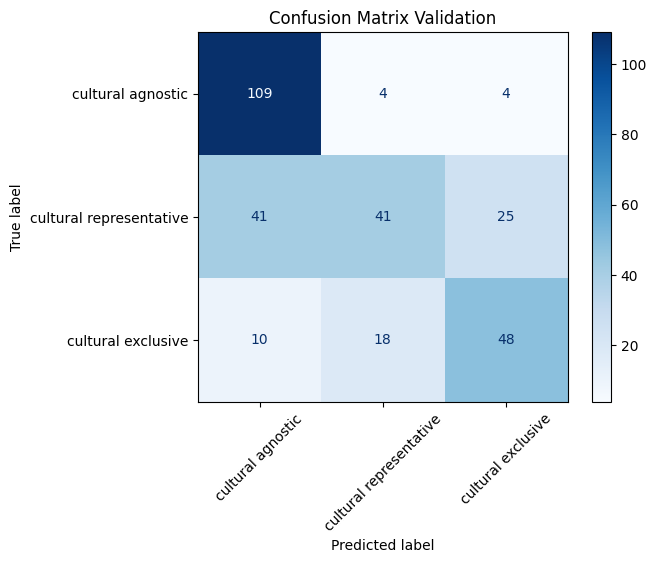

In [12]:
train_embedded=np.load("train_sample_embeddings.npz")
centroids=np.load("centroids_every_label.npz")
weights=np.load("weights_properties_MI.npz")
valid_embedded=np.load("X_valid_embedded.npz")
X_valid_emb=valid_embedded["validation_embedded"]
Y_true_valid=numerical_label(X_valid[0:,6])
print(Y_true_valid)
Y_pred=np.zeros(X_valid_emb.shape[0])

for i in range(0,X_valid_emb.shape[0]):
    index_class_valid=predict_entity_score(X_valid_emb[i],centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"],weights["weight_properties"])
    print(index_class_valid)
    Y_pred[i]=index_class_valid
print(accuracy_score(Y_true_valid,Y_pred))
#metrics on validation
labels=["cultural agnostic","cultural representative","cultural exclusive"]
report=classification_report(Y_pred,Y_true_valid, target_names=labels)
print("classification report:\n",report)
with open("classification_report_validation.txt", "w") as f:
    f.write(report)

cm_validation=confusion_matrix(Y_true_valid,Y_pred,labels=[0,1,2])
disp_conf_matrix=ConfusionMatrixDisplay(confusion_matrix=cm_validation,display_labels=labels)
disp_conf_matrix.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix Validation")
#plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_validation.png")
plt.close()



In [ ]:
start_time = time.time()
print("Embedding culture representative samples (GPU)")
culture_representative_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural representative'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture representative sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding culture agnostic sample (GPU)")
culture_agnostic_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural agnostic'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture agnostic sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding Culture exclusive sample (GPU)")
culture_exclusive_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural exclusive'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding Culture exclusive sample time: {time.time() - start_time:.4f} seconds")

print(f"culture_agnostic_train_gpu: {culture_agnostic_train_gpu.cpu().numpy()}")
print(f"cutlure agnostic shape {culture_agnostic_train_gpu.shape}")
print(f"culture_representative_train_gpu {culture_representative_train_gpu.cpu().numpy()}")
print(f"culture_representative_train_gpu shape {culture_representative_train_gpu.shape}")
print(f"culture_exclusive_train_gpu {culture_exclusive_train_gpu.cpu().numpy()}")
print(f"culture_exclusive_train_gpu shape {culture_exclusive_train_gpu.shape}")

# Calcolo dei centroidi sulla GPU
centroid_agnostic_gpu = culture_agnostic_train_gpu.float().mean(dim=0)
print(f"centroid agnostic for each property (GPU) {centroid_agnostic_gpu.shape}", centroid_agnostic_gpu.cpu().numpy())
centroid_representative_gpu = culture_representative_train_gpu.float().mean(dim=0)
print(f"centroid_representative (GPU) {centroid_representative_gpu.shape}", centroid_representative_gpu.cpu().numpy())
centroid_exclusive_gpu = culture_exclusive_train_gpu.float().mean(dim=0)
print(f"centroid_exclusive (GPU) {centroid_exclusive_gpu.shape}", centroid_exclusive_gpu.cpu().numpy())

# Calcolo di sigma basato sui dati embeddati (ora su GPU)
all_data_gpu = t.cat([
    culture_agnostic_train_gpu.float(),
    culture_representative_train_gpu.float(),
    culture_exclusive_train_gpu.float()
], dim=0)
distances_gpu = t.cdist(all_data_gpu, all_data_gpu)
sigma_gpu = 1 / (t.sqrt(t.tensor(2.0, device=device)) * (distances_gpu.mean() + 1e-8))

# Calcolo dei pesi con il kernel gaussiano (ora sugli embedding sulla GPU)
embeddings_agnostic_gpu = culture_agnostic_train_gpu.float()
weights_agnostic_gpu = gaussian_kernel_estimation_torch(embeddings_agnostic_gpu, centroid_agnostic_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_representative_gpu = culture_representative_train_gpu.float()
weights_representative_gpu = gaussian_kernel_estimation_torch(embeddings_representative_gpu, centroid_representative_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_exclusive_gpu = culture_exclusive_train_gpu.float()
weights_exclusive_gpu = gaussian_kernel_estimation_torch(embeddings_exclusive_gpu, centroid_exclusive_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

# Normalizzazione dei pesi (ora su GPU)
weights_agnostic_gpu /= (weights_agnostic_gpu.sum() + 1e-8)
print("weights agnostic normalized for every property (GPU)")
weights_representative_gpu /= (weights_representative_gpu.sum() + 1e-8)
weights_exclusive_gpu /= (weights_exclusive_gpu.sum() + 1e-8)

# Funzione di predizione ottimizzata per la GPU (gestisce input NumPy e lo sposta sulla GPU)
def predict_entity_score_optimized_gpu(x_sample_np, centroid_CA_gpu, centroid_CR_gpu, centroid_CE_gpu,
                                      weights_agnostic_gpu, weights_representative_gpu, weights_exclusive_gpu,
                                      sigma_gpu):
    """Predice il punteggio di appartenenza usando tensori PyTorch sulla GPU."""
    x_sample = t.tensor(x_sample_np, dtype=t.float32, device=centroid_CA_gpu.device)

    similarity_sample_CA = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CA_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CR = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CR_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CE = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CE_gpu.unsqueeze(0), sigma_gpu)

    weighted_sample_agnostic = x_sample * weights_agnostic_gpu
    weighted_sample_representative = x_sample * weights_representative_gpu
    weighted_sample_exclusive = x_sample * weights_exclusive_gpu

    total_score_agnostic = weighted_sample_agnostic.sum() * similarity_sample_CA
    total_score_representative = weighted_sample_representative.sum() * similarity_sample_CR
    total_score_exclusive = weighted_sample_exclusive.sum() * similarity_sample_CE

    return t.argmax(t.stack([total_score_agnostic, total_score_representative, total_score_exclusive])).item()

# Esempio di predizione
if X_train.shape[1] > len(vocabulary):
    sample_to_predict = np.random.rand(len(vocabulary)) # Crea un campione casuale di embedding
else:
    sample_to_predict = np.random.rand(len(vocabulary)) # Genera un campione casuale se X_train non ha abbastanza colonne

prediction = predict_entity_score_optimized_gpu(
    sample_to_predict,
    centroid_agnostic_gpu,
    centroid_representative_gpu,
    centroid_exclusive_gpu,
    weights_agnostic_gpu,
    weights_representative_gpu,
    weights_exclusive_gpu,
    sigma_gpu
)
print(f"Prediction for sample: {prediction}")